In [1]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import pathlib 
import numpy as np

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.12.0
Eager execution: True


In [2]:
data_root = './cars_train'
data_root = pathlib.Path(data_root)

all_image_paths = sorted([str(path) for path in data_root.iterdir()])

len(all_image_paths)

8144

In [3]:
traindata = pd.read_csv('traindata.csv', index_col=0)

In [4]:
train_paths = all_image_paths
train_labels = traindata['class'].tolist()

train_bbox = traindata[['bbox1', 'bbox2', 'bbox3', 'bbox4']].values.tolist()
train_bbox = np.array(train_bbox, dtype=np.str)

all_image_paths = np.array(all_image_paths).reshape((-1, 1))

all_image_paths = np.concatenate((all_image_paths, train_bbox), axis=1)

In [5]:
def preprocess_image(image, bbox):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.crop_to_bounding_box(image, bbox[1], bbox[0], bbox[3]-bbox[1],
                                          bbox[2] - bbox[0])
    image = tf.image.resize_images(image, [224, 224])
    image = (image - 127.5)/127.5  # normalize to [-1,1] range
    return image

In [6]:
def load_and_preprocess_image(path):
    image = tf.read_file(path[0])
    return preprocess_image(image, tf.string_to_number(path[1:], out_type=tf.int32))

# Build the Dataset

In [7]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = path_ds.map(load_and_preprocess_image)

label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(np.array(train_labels) - 1, tf.int64))

image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [8]:
print('image shape: ', image_label_ds.output_shapes[0])
print('label shape: ', image_label_ds.output_shapes[1])
print('types: ', image_label_ds.output_types)
print()
print(image_label_ds)

image shape:  (224, 224, 3)
label shape:  ()
types:  (tf.float32, tf.int64)

<ZipDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>


In [9]:
BATCH_SIZE = 32
image_count = len(all_image_paths)
# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=64)
ds

<PrefetchDataset shapes: ((?, 224, 224, 3), (?,)), types: (tf.float32, tf.int64)>

# Pass Dataset to model

In [10]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False)
mobile_net.trainable=True

In [11]:
model = tf.keras.Sequential([mobile_net,tf.keras.layers.GlobalAveragePooling2D(),
                            tf.keras.layers.Dense(196, activation='softmax')])

optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 196)               251076    
Total params: 2,509,060
Trainable params: 2,474,948
Non-trainable params: 34,112
_________________________________________________________________


In [13]:
# # Test Dataset Performace
# import time
# steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
# steps_per_epoch


# default_timeit_steps = 2*steps_per_epoch+1

# def timeit(ds, steps=default_timeit_steps):
#     overall_start = time.time()
#     # Fetch a single batch to prime the pipeline (fill the shuffle buffer),
#     # before starting the timer
#     it = iter(ds.take(steps+1))
#     next(it)

#     start = time.time()
#     for i,(images,labels) in enumerate(it):
#         if i%10 == 0:
#             print('.',end='')
#     print()
#     end = time.time()

#     duration = end-start
#     print("{} batches: {} s".format(steps, duration))
#     print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))
#     print("Total time: {}s".format(end-overall_start))

In [14]:
# timeit(ds)

In [13]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])

In [14]:
batch_stats = CollectBatchStats()
steps_per_epoch=tf.ceil(len(all_image_paths)/BATCH_SIZE).numpy().astype(np.int)
model.fit(ds, epochs=8, steps_per_epoch=steps_per_epoch, callbacks = [batch_stats])

Epoch 1/8
255/255 [==============================] - 162s 637ms/step - loss: 4.6174 - acc: 0.1067
Epoch 2/8
255/255 [==============================] - 107s 421ms/step - loss: 2.2956 - acc: 0.5828
Epoch 3/8
255/255 [==============================] - 110s 430ms/step - loss: 1.0499 - acc: 0.8442
Epoch 4/8
255/255 [==============================] - 108s 424ms/step - loss: 0.4941 - acc: 0.9489
Epoch 5/8
255/255 [==============================] - 109s 429ms/step - loss: 0.2444 - acc: 0.9832
Epoch 6/8
255/255 [==============================] - 110s 429ms/step - loss: 0.1315 - acc: 0.9947
Epoch 7/8
255/255 [==============================] - 103s 404ms/step - loss: 0.0812 - acc: 0.9964
Epoch 8/8
255/255 [==============================] - 110s 431ms/step - loss: 0.0559 - acc: 0.9969


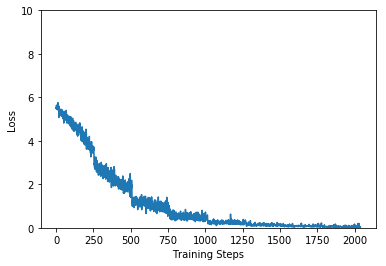

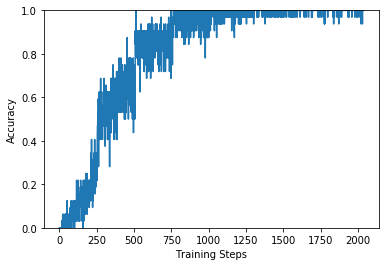

In [15]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,10])
plt.plot(batch_stats.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)



In [16]:
model.save_weights("model.h5")

# TestSet

In [17]:
model2 = tf.keras.Sequential([mobile_net,tf.keras.layers.GlobalAveragePooling2D(),
                            tf.keras.layers.Dense(196, activation='softmax')])

optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
model2.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])
model2.load_weights('./model.h5')

In [18]:
testdata = pd.read_csv('testdata.csv', index_col=0)

In [19]:
test_data_root = './cars_test'
test_data_root = pathlib.Path(test_data_root)

test_paths = sorted([str(path) for path in test_data_root.iterdir()])

len(test_paths)

8041

In [20]:
test_labels = testdata['class'].tolist()

test_bbox = testdata[['bbox1', 'bbox2', 'bbox3', 'bbox4']].values.tolist()
test_bbox = np.array(test_bbox, dtype=np.str)

test_paths = np.array(test_paths).reshape((-1, 1))

test_paths = np.concatenate((test_paths, test_bbox), axis=1)

In [21]:
test_path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
test_image_ds = test_path_ds.map(load_and_preprocess_image)

In [22]:
test_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(np.array(test_labels) - 1, tf.int64))

test_image_label_ds = tf.data.Dataset.zip((test_image_ds, test_label_ds))
test_image_label_ds = test_image_label_ds.batch(BATCH_SIZE)

In [23]:
model2.evaluate(test_image_label_ds, steps=tf.ceil(len(test_paths)/BATCH_SIZE).numpy().astype(np.int))

252/252 [==============================] - 76s 302ms/step


[0.9062630948832402, 0.782738465372417]